# Sentiment Analysis of Aviation Accident Narratives

**Objective**: Analyze sentiment of accident investigation narratives and correlate with fatal outcomes using VADER.

**Methods**: VADER sentiment analysis, outcome correlation, severity analysis

**Date**: 2025-11-08

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
analyzer = SentimentIntensityAnalyzer()
print('✅ Libraries and VADER loaded')

✅ Libraries and VADER loaded


In [2]:
df = pd.read_parquet('../../data/narratives_dataset.parquet')
df['full_narrative'] = (df['narr_accp'].fillna('') + ' ' + df['narr_cause'].fillna('')).str.strip()
df = df[df['full_narrative'].str.len() > 0].reset_index(drop=True)
df['fatal_outcome'] = df['inj_tot_f'] > 0
print(f'✅ Loaded {len(df):,} narratives')

✅ Loaded 67,126 narratives


In [3]:
# Analyze sentiment (sample for speed)
sample_size = 15000
sample_df = df.sample(n=min(sample_size, len(df)), random_state=42).copy()

print(f'🔄 Analyzing sentiment for {len(sample_df):,} narratives...')
sample_df['sentiment_scores'] = sample_df['full_narrative'].apply(lambda x: analyzer.polarity_scores(x[:2000]))
sample_df['sentiment_compound'] = sample_df['sentiment_scores'].apply(lambda x: x['compound'])
sample_df['sentiment_pos'] = sample_df['sentiment_scores'].apply(lambda x: x['pos'])
sample_df['sentiment_neg'] = sample_df['sentiment_scores'].apply(lambda x: x['neg'])
sample_df['sentiment_neu'] = sample_df['sentiment_scores'].apply(lambda x: x['neu'])

sample_df['sentiment_label'] = sample_df['sentiment_compound'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)

print('✅ Sentiment analysis complete')

🔄 Analyzing sentiment for 15,000 narratives...


✅ Sentiment analysis complete


In [4]:
# Sentiment distribution
print('Sentiment Label Distribution:\n')
print(sample_df['sentiment_label'].value_counts())
print(f'\nMean compound score: {sample_df["sentiment_compound"].mean():.3f}')
print(f'Median compound score: {sample_df["sentiment_compound"].median():.3f}')
print(f'Std compound score: {sample_df["sentiment_compound"].std():.3f}')

Sentiment Label Distribution:

sentiment_label
negative    14025
positive      608
neutral       367
Name: count, dtype: int64

Mean compound score: -0.746
Median compound score: -0.896
Std compound score: 0.345


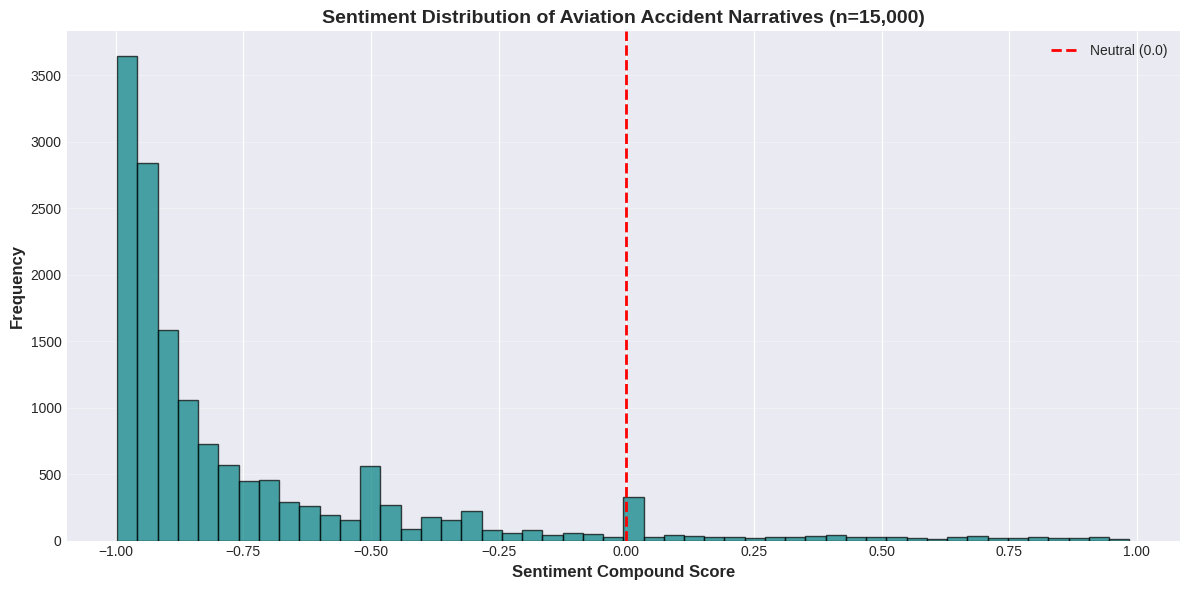

✅ Sentiment distribution plot saved


In [5]:
# Sentiment distribution histogram
plt.figure(figsize=(12, 6))
plt.hist(sample_df['sentiment_compound'], bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral (0.0)')
plt.xlabel('Sentiment Compound Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title(f'Sentiment Distribution of Aviation Accident Narratives (n={len(sample_df):,})', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/sentiment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Sentiment distribution plot saved')

In [6]:
# Sentiment by fatal outcome
fatal_sentiment = sample_df.groupby('fatal_outcome')['sentiment_compound'].describe()
print('Sentiment by Fatal Outcome:\n')
print(fatal_sentiment)

# Statistical test
fatal_scores = sample_df[sample_df['fatal_outcome']]['sentiment_compound']
nonfatal_scores = sample_df[~sample_df['fatal_outcome']]['sentiment_compound']
t_stat, p_value = stats.ttest_ind(fatal_scores, nonfatal_scores)
print(f'\nMann-Whitney U test: p={p_value:.4f} (significant: {p_value < 0.05})')

Sentiment by Fatal Outcome:

                 count      mean       std     min     25%     50%     75%  \
fatal_outcome                                                                
False          12062.0 -0.731922  0.353672 -0.9970 -0.9538 -0.8845 -0.6525   
True            2938.0 -0.805394  0.301369 -0.9959 -0.9643 -0.9235 -0.8020   

                  max  
fatal_outcome          
False          0.9854  
True           0.9704  

Mann-Whitney U test: p=0.0000 (significant: True)


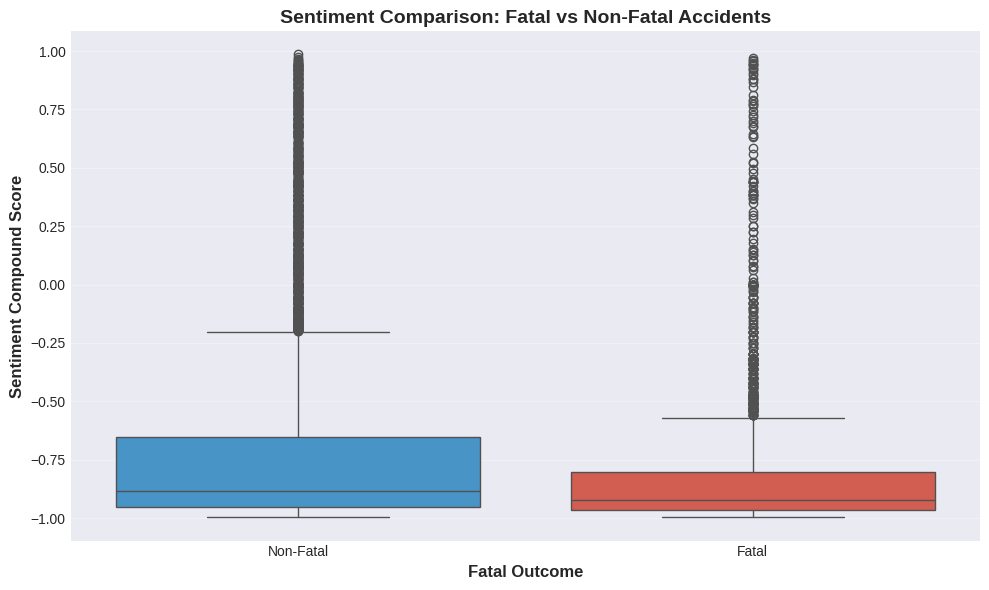

✅ Sentiment comparison plot saved


In [7]:
# Box plot: sentiment by outcome
plt.figure(figsize=(10, 6))
sns.boxplot(data=sample_df, x='fatal_outcome', y='sentiment_compound', palette=['#3498db', '#e74c3c'])
plt.xlabel('Fatal Outcome', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Compound Score', fontsize=12, fontweight='bold')
plt.title('Sentiment Comparison: Fatal vs Non-Fatal Accidents', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Non-Fatal', 'Fatal'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/sentiment_fatal_vs_nonfatal.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Sentiment comparison plot saved')


Mean Sentiment by Injury Severity:

ev_highest_injury
FATL   -0.804362
MINR   -0.752139
SERS   -0.738498
NONE   -0.734739
Name: sentiment_compound, dtype: float64


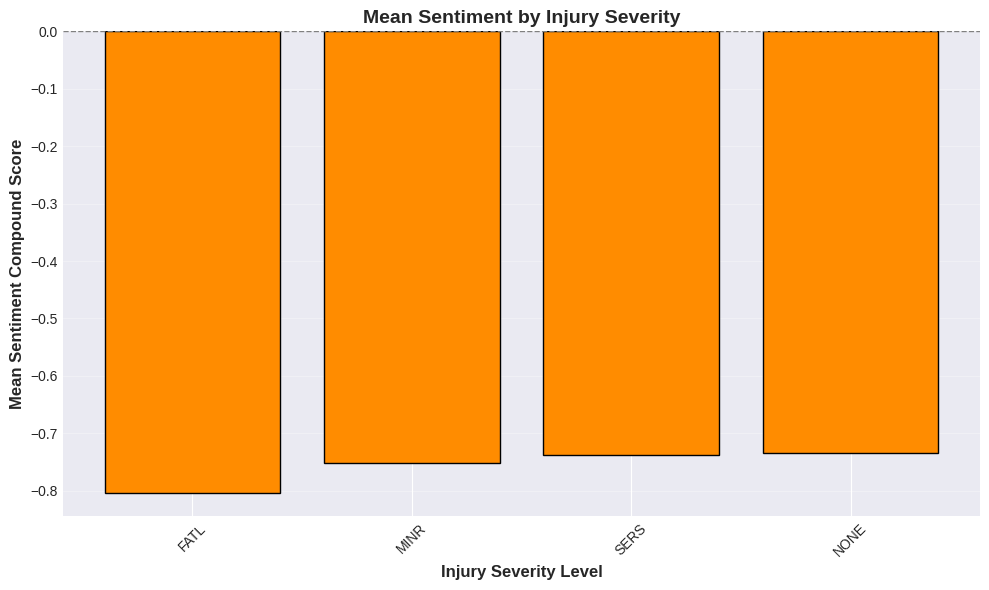

✅ Severity sentiment plot saved


In [8]:
# Sentiment by injury severity
severity_sentiment = sample_df.groupby('ev_highest_injury')['sentiment_compound'].mean().sort_values()
print('\nMean Sentiment by Injury Severity:\n')
print(severity_sentiment)

plt.figure(figsize=(10, 6))
plt.bar(range(len(severity_sentiment)), severity_sentiment.values, color='darkorange', edgecolor='black')
plt.xticks(range(len(severity_sentiment)), severity_sentiment.index, rotation=45)
plt.xlabel('Injury Severity Level', fontsize=12, fontweight='bold')
plt.ylabel('Mean Sentiment Compound Score', fontsize=12, fontweight='bold')
plt.title('Mean Sentiment by Injury Severity', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/sentiment_by_severity.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Severity sentiment plot saved')

In [9]:
# Export sentiment results
sentiment_results = sample_df[['ev_id', 'ev_year', 'sentiment_compound', 'sentiment_label', 'fatal_outcome', 'ev_highest_injury']]
sentiment_results.to_csv('../../data/sentiment_analysis_results.csv', index=False)
print('✅ Sentiment results exported to: data/sentiment_analysis_results.csv')

print('\n='*70)
print('SENTIMENT ANALYSIS SUMMARY')
print('='*70)
print(f'Narratives analyzed: {len(sample_df):,}')
print(f'Mean sentiment: {sample_df["sentiment_compound"].mean():.3f}')
print(f'Positive narratives: {(sample_df["sentiment_label"] == "positive").sum():,} ({(sample_df["sentiment_label"] == "positive").mean()*100:.1f}%)')
print(f'Negative narratives: {(sample_df["sentiment_label"] == "negative").sum():,} ({(sample_df["sentiment_label"] == "negative").mean()*100:.1f}%)')
print(f'Neutral narratives: {(sample_df["sentiment_label"] == "neutral").sum():,} ({(sample_df["sentiment_label"] == "neutral").mean()*100:.1f}%)')
print(f'\nFatal vs Non-Fatal: p={p_value:.4f}')
print('\n✅ Sentiment analysis complete!')
print('='*70)

✅ Sentiment results exported to: data/sentiment_analysis_results.csv

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
SENTIMENT ANALYSIS SUMMARY
Narratives analyzed: 15,000
Mean sentiment: -0.746
Positive narratives: 608 (4.1%)
Negative narratives: 14,025 (93.5%)
Neutral narratives: 367 (2.4%)

Fatal vs Non-Fatal: p=0.0000

✅ Sentiment analysis complete!
